# Generative adversarial networks

+ based on https://github.com/mingyuliutw/cvpr2017_gan_tutorial
+ see also [VAE example](pymc_vae.ipynb).
  + unlike VAEs, GANs just provides sample generators, not explicit distributions.
  + if you are looking for feature embedding like VAEs, see AAEs.

## Problem definition

### basic objective function

\begin{align}
\min_{G} \max_{D} \mathbf{E}_{x \sim p(x)}[\log D(x)] + \mathbf{E}_{z \sim p(z)}[\log (1 - D(G(z)))]
\end{align}
where
+ $D, G$ are neural networks
+ $D$ discriminates that $x$ is sampled from real or $G$ as $D(x) = \frac{ p_{x \sim X}(x) }{ p_{x \sim X}(x) + p_{x \sim G(z)}(x) }$
+ Optimal $G$ needs to remeber $O(n \log n)$ samples, where $n$ is $D$'s capacity. Hence the effect of the amount of training data is limited. http://proceedings.mlr.press/v70/arora17a.html
+ $p(z)$ is usually uniform or Gaussian


### practical objective 

1. Fix $G$ and optimize: $ \max_{D} \mathbf{E}_{x \sim p(x)}[\log D(x)] + \mathbf{E}_{z \sim p(z)}[\log (1 - D(G(z)))]$
2. Fix $D$ and optimize: $ \max_G \mathbf{E}_{z \sim p(z)}[\log D(G(z)))]$ (different from basic objective because of log curve)



In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy
import theano
import theano.tensor as tt
from torchvision import datasets

import t721.leaf as L
import t721.optimizer as O

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 760 (0000:01:00.0)


### GAN's specification

the weakness of GANs is "mode collapse". GANs tend to get stuck at local minimum i.e., GANs cannot fully cover every modes in the input space.

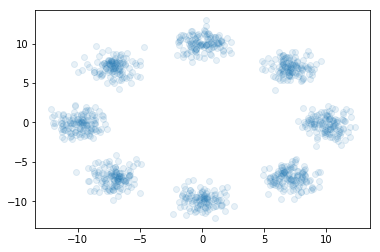

In [2]:
floatX = theano.config.floatX

def gaussian_mixture_circle(batchsize, num_cluster=8, scale=1, std=1):
    rand_indices = numpy.random.randint(0, num_cluster, size=batchsize)
    base_angle = numpy.pi * 2 / num_cluster
    angle = rand_indices * base_angle - numpy.pi / 2
    mean = numpy.zeros((batchsize, 2), dtype=floatX)
    mean[:, 0] = numpy.cos(angle) * scale
    mean[:, 1] = numpy.sin(angle) * scale
    return numpy.random.normal(mean, std**2, (batchsize, 2)).astype(floatX)

samples = gaussian_mixture_circle(1000, scale=10)
fig = plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

In [3]:
import t721.initializer as I
class GAN(L.Leaf):
    def __init__(self, lr=1e-3, activation=tt.nnet.sigmoid, n_layers=3, weight_init=I.XavierUniform(),
                 n_rand=128, n_g_hidden=512, n_d_hidden=32, n_input=2, n_d_output=1):
        self.n_rand = n_rand
        self.rng = tt.shared_randomstreams.RandomStreams()        
        self.g = L.MLP(n_rand, n_g_hidden, n_input, n_layers=n_layers, activation=activation, weight_init=weight_init)
        self.d = L.MLP(n_input, n_d_hidden, n_d_output, n_layers=n_layers, activation=activation, weight_init=weight_init)

        n_sample = tt.lscalar("n_sample")
        self.generate = theano.function([n_sample], self.g(self.rng.normal((n_sample, n_rand))))
        
        xs = tt.matrix("xs")
        d_loss = self.d_loss(xs)
        d_optimizer = O.Adam(lr)
        self.train_d = theano.function([xs], d_loss, updates=self.d.optimize(d_loss, d_optimizer))

        g_loss = self.g_loss(n_sample)
        g_optimizer = O.Adam(lr)
        self.train_g = theano.function([n_sample], g_loss, updates=self.g.optimize(g_loss, g_optimizer))

    def loss(self, xs, ts):
        ys = tt.nnet.sigmoid(self.d(xs))
        loss = tt.mean(tt.nnet.binary_crossentropy(ys.reshape([-1]), ts))
        return loss

        
    def d_loss(self, xs):
        n_batch = xs.shape[0]
        gs = self.g(self.rng.normal((n_batch, self.n_rand)))
        gxs = tt.concatenate([xs, gs])
        gts = tt.concatenate([tt.ones([n_batch], dtype=numpy.int64),
                              tt.zeros([n_batch], dtype=numpy.int64)])
        return self.loss(gxs, gts)

    def g_loss(self, n_batch):
        xs = self.g(self.rng.normal((n_batch, self.n_rand)))
        ts = tt.ones([n_batch], dtype=numpy.int64)
        return self.loss(xs, ts)

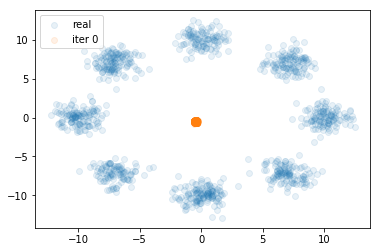

Discriminator: 0.6305860571404435,	Generator: 0.9374543638803065


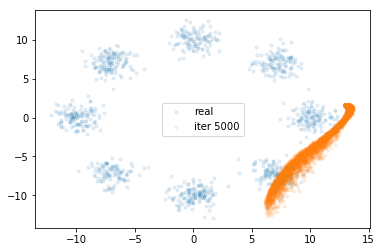

Discriminator: 0.6480134062590185,	Generator: 0.860081419209484


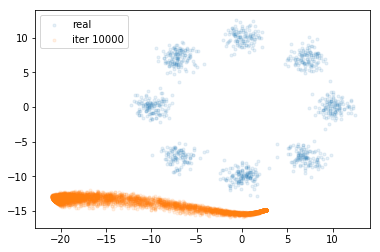

Discriminator: 0.6546386567887533,	Generator: 0.8255980657693309


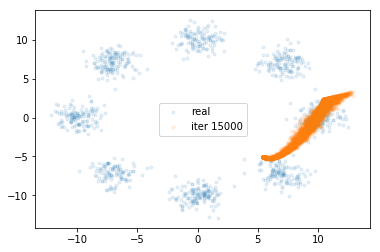

Discriminator: 0.6610095191319497,	Generator: 0.801249821655557


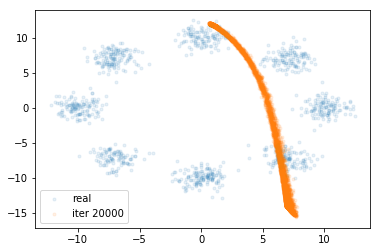

Discriminator: 0.6636049991389164,	Generator: 0.793570457586404


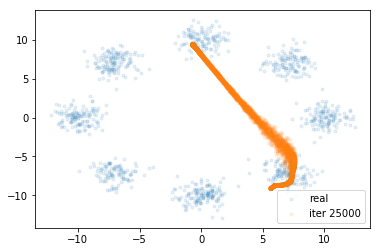

Discriminator: 0.6609105611576163,	Generator: 0.7937544674565783


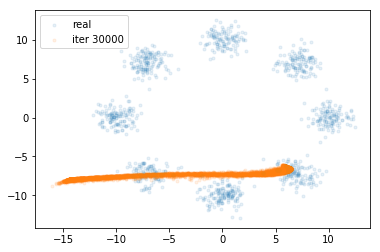

Discriminator: 0.6535929541774392,	Generator: 0.8065577448446092


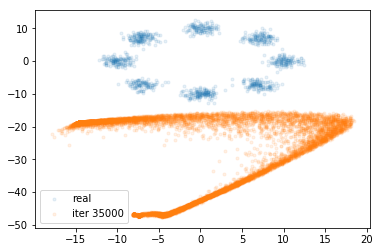

Discriminator: 0.6557598481115496,	Generator: 0.7994746432373522


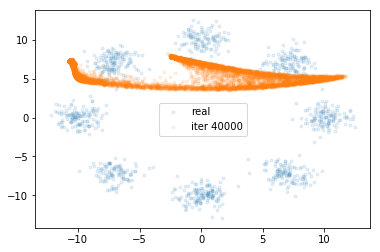

Discriminator: 0.6575015295251988,	Generator: 0.7945014466985248


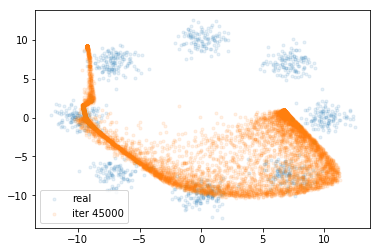

In [20]:
from collections import namedtuple

n_sample = 10000
n_cluster = 8
scale = 10
real = gaussian_mixture_circle(1000, num_cluster=n_cluster, scale=scale)
plt.scatter(real[:, 0], real[:, 1], alpha=0.1)

model = GAN(lr=1e-3)
n_batch = 32
gs = model.generate(n_sample)
plt.scatter(gs[:, 0], gs[:, 1], alpha=0.1)
plt.legend(["real", "iter 0"])
plt.show()

n_iters = 50000
n_interval = n_iters // 10
d_loss = 0
g_loss = 0
Result = namedtuple("Result", ["iter", "dloss", "gloss", "samples"])
results = []
for i in range(1, n_iters):
    xs = gaussian_mixture_circle(n_batch, num_cluster=n_cluster, scale=scale)
    d_loss += model.train_d(xs)
    g_loss += model.train_g(n_batch * 2)
    if numpy.isnan(d_loss + g_loss):
        print("nan detected!")
        break
    if i % n_interval == 0:
        print("Discriminator: {},\tGenerator: {}".format(d_loss / i, g_loss / i))
        plt.scatter(real[:, 0], real[:, 1], alpha=0.1, marker=".")
        gs = model.generate(n_sample)
        plt.scatter(gs[:, 0], gs[:, 1], alpha=0.1, marker=".")
        plt.legend(["real", "iter %d" % i])
        plt.show()
        results.append(Result(i, d_loss / i, g_loss / i, gs))

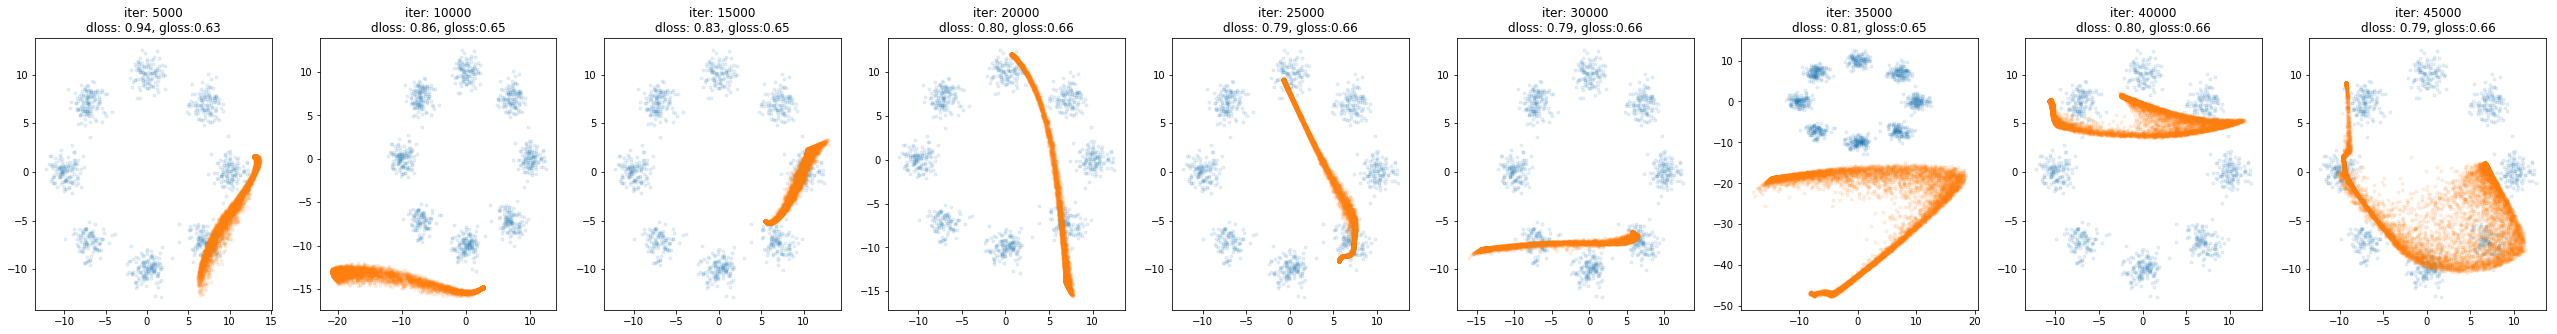

In [21]:
n = len(results)
fig = plt.figure(figsize=(n * 5,  5)) 
for i, r in enumerate(results, 1):
    plt.subplot(1, n, i)
    plt.scatter(real[:, 0], real[:, 1], alpha=0.1, marker=".")
    plt.scatter(r.samples[:, 0], r.samples[:, 1], alpha=0.1, marker=".")
    plt.title("iter: {}\ndloss: {:.2f}, gloss:{:.2f}".format(r.iter, r.gloss, r.dloss))

## Unroll optimization of the discrimiantor

https://arxiv.org/pdf/1611.02163.pdf

The main strategy of unrolled GAN is to make generators knows future (N steps further) discriminators because discriminators often dominate (i.e. too stronger than generators) the trainig loss.


+ TODO: the referrence code https://github.com/poolio/unrolled_gan/blob/master/Unrolled%20GAN%20demo.ipynb
  contains backpropagation through unrolling that I haven't understood yet as follows:

``` python
if params['unrolling_steps'] > 0:
    # Get dictionary mapping from variables to their update value after one optimization step
    update_dict = extract_update_dict(updates)
    cur_update_dict = update_dict
    for i in xrange(params['unrolling_steps'] - 1):
        # Compute variable updates given the previous iteration's updated variable
        cur_update_dict = graph_replace(update_dict, cur_update_dict)
    # Final unrolled loss uses the parameters at the last time step
    unrolled_loss = graph_replace(loss, cur_update_dict)
else:
    unrolled_loss = loss
```

+ existing implementation using theano.clone and scan
  + https://github.com/bstriner/keras-adversarial/blob/master/keras_adversarial/unrolled_optimizer.py
  + https://www.reddit.com/r/MachineLearning/comments/5q5bmq/d_how_do_unrolled_gans_work_implementation/
  + is SGD can be held by scan?

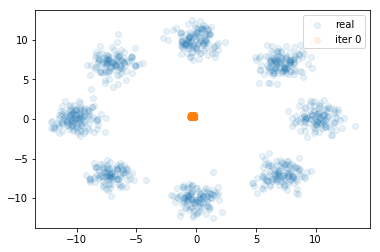

Discriminator: 0.7020528148557059,	Generator: 0.7418726476374082


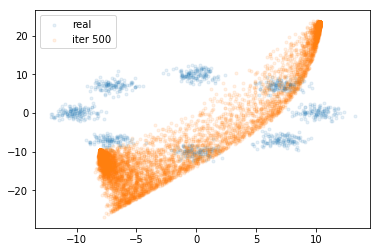

Discriminator: 0.6985611091337632,	Generator: 0.7214351397270803


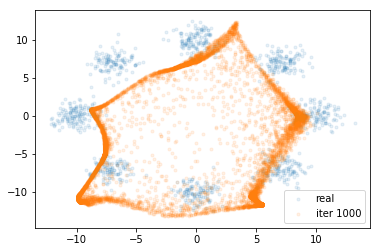

Discriminator: 0.6969539217978405,	Generator: 0.7133849674466066


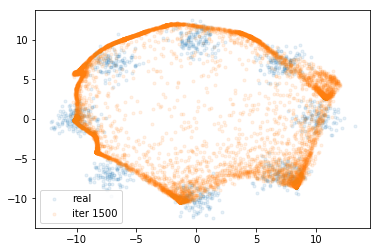

Discriminator: 0.6960923107255949,	Generator: 0.7090751059498405


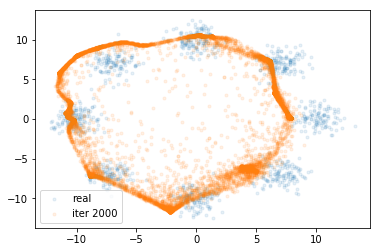

Discriminator: 0.6955491223963909,	Generator: 0.7063148559696414


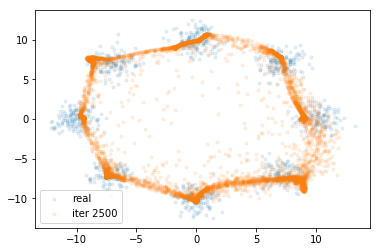

Discriminator: 0.6951944042496228,	Generator: 0.7044084116139604


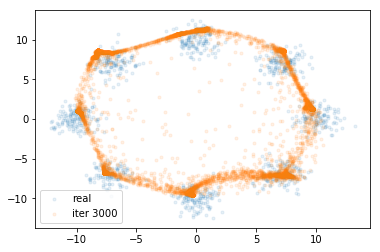

Discriminator: 0.6949314406774273,	Generator: 0.7030272244673621


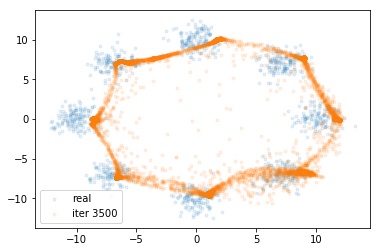

Discriminator: 0.6947457136033918,	Generator: 0.7019630375773762


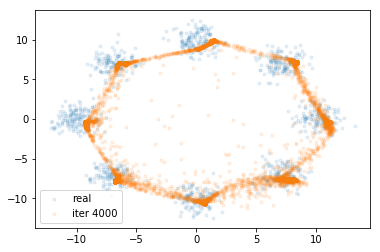

Discriminator: 0.6945963940220471,	Generator: 0.7011349818434877


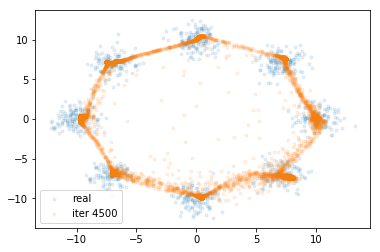

In [15]:
# Unrolled GAN
n_sample = 10000
n_cluster = 8
scale = 10
real = gaussian_mixture_circle(1000, num_cluster=n_cluster, scale=scale)
plt.scatter(real[:, 0], real[:, 1], alpha=0.1)

model = GAN(lr=1e-3)
n_batch = 32
gs = model.generate(n_sample)
plt.scatter(gs[:, 0], gs[:, 1], alpha=0.1)
plt.legend(["real", "iter 0"])
plt.show()

n_unroll = 10
n_iters = 50000 // n_unroll
n_interval = n_iters // 10
d_loss = 0
g_loss = 0
ugan_results = []
for i in range(1, n_iters):
    xs = gaussian_mixture_circle(n_batch, num_cluster=n_cluster, scale=scale)
    d_loss += model.train_d(xs)
    d_save = [p.get_value() for p in model.d.get_params()]

    for n in range(n_unroll):
        xs = gaussian_mixture_circle(n_batch, num_cluster=n_cluster, scale=scale)
        model.train_d(xs)
        g_loss += model.train_g(n_batch * 2)
    # FIXME: rewrite with theano.clone
    for p, p_prev in zip(model.d.get_params(), d_save):
        p.set_value(p_prev)

    if numpy.isnan(d_loss + g_loss):
        print("nan detected!")
        break
    if i % n_interval == 0:
        print("Discriminator: {},\tGenerator: {}".format(d_loss / i, g_loss / (i * n_unroll)))
        plt.scatter(real[:, 0], real[:, 1], alpha=0.1, marker=".")
        gs = model.generate(n_sample)
        plt.scatter(gs[:, 0], gs[:, 1], alpha=0.1, marker=".")
        plt.legend(["real", "iter %d" % i])
        plt.show()
        ugan_results.append(Result(i * n_unroll, d_loss / i, g_loss / (i * n_unroll), gs))

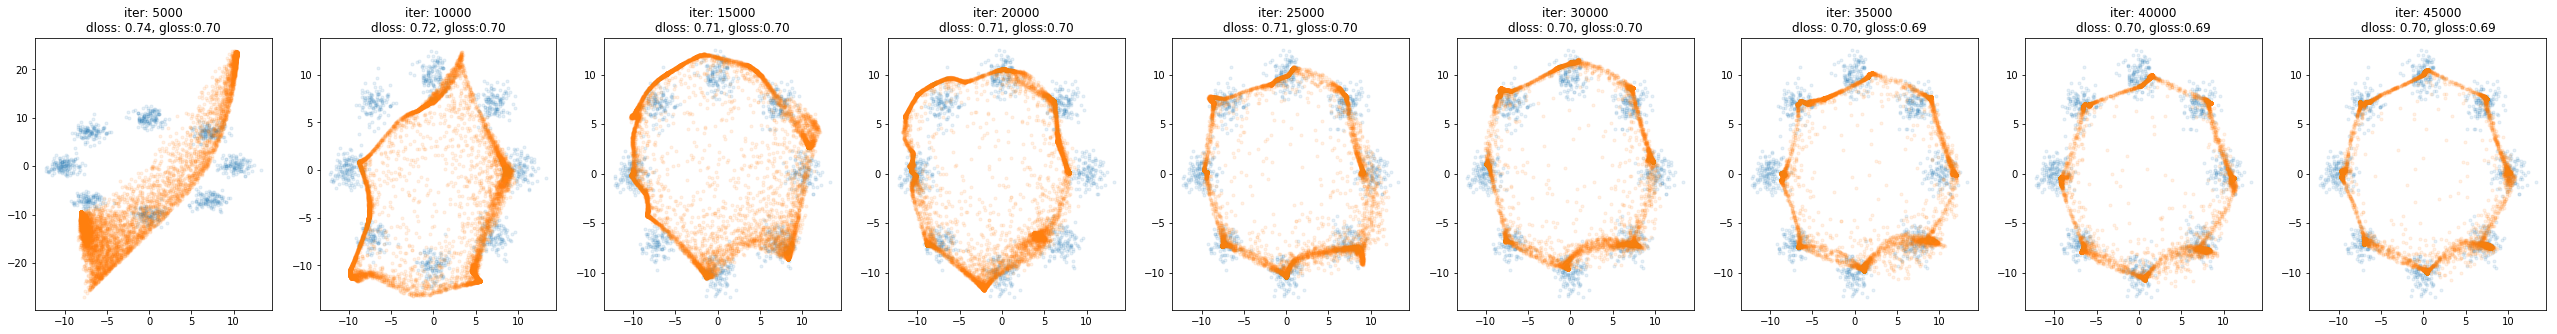

In [16]:
n = len(ugan_results)
fig = plt.figure(figsize=(n * 5,  5)) 
for i, r in enumerate(ugan_results, 1):
    plt.subplot(1, n, i)
    plt.scatter(real[:, 0], real[:, 1], alpha=0.1, marker=".")
    plt.scatter(r.samples[:, 0], r.samples[:, 1], alpha=0.1, marker=".")
    plt.title("iter: {}\ndloss: {:.2f}, gloss:{:.2f}".format(r.iter, r.gloss, r.dloss))

In [8]:
# in theano, we can replace some nodes with clone like tensorflow?
import theano.tensor as T
import theano

a = T.vector()
b = T.matrix()
fa = a ** 2
f = theano.function([a], fa)
f2 = theano.function([b], theano.clone(fa, replace={a: b}, strict=False))
print(f([2]))
print(f2([[2]]))

[ 4.]
[[ 4.]]


## new objective functions

### Wasserstein loss

https://arxiv.org/pdf/1701.07875.pdf

In WGAN, the discriminators and generators won't compete. The discriminators just targets to acquire the accurate Wasserstein (Earth mover) metric, while the generators just targets to maximize the metric of their samples. Hence, the discriminators should be over trained than generators unlike the unrolled GAN.

1. Fix $G$ and optimize: $ \max_{D} \mathbf{E}_{x \sim p(x)}[D(x)] - \mathbf{E}_{z \sim p(z)}[ D(G(z))]$ at several times
2. Fix $D$ and optimize: $ \max_G \mathbf{E}_{z \sim p(z)}[D(G(z))]$

Note that, to satisfy Lipschitz condition, the parameters of discriminators are limited to small range.

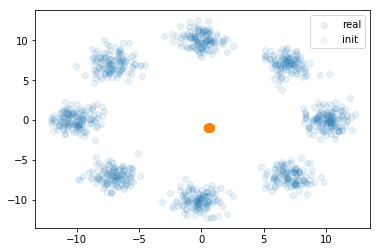

Discriminator: -0.0002283560338616371,	Generator: 0.5776842136736959


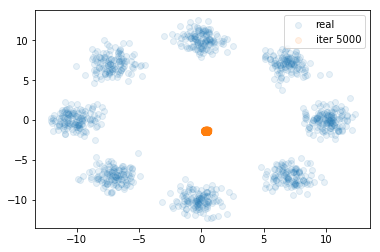

Discriminator: -0.00032288092290982603,	Generator: 0.5739302274156362


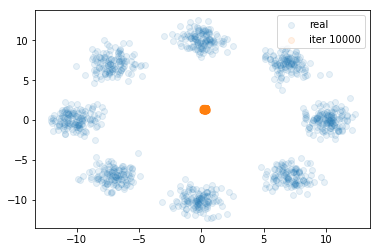

Discriminator: -0.0004088826961815357,	Generator: 0.5744809187720841


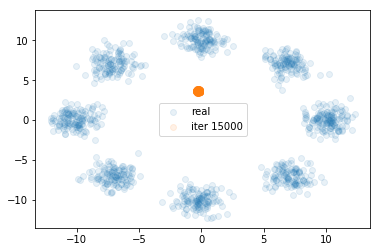

Discriminator: -0.000504331864323467,	Generator: 0.5772632961565163


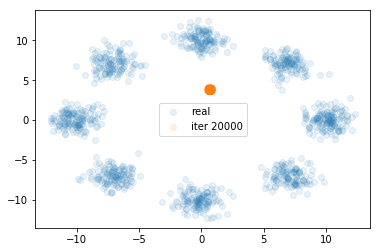

Discriminator: -0.0006020377837195992,	Generator: 0.5798159426347539


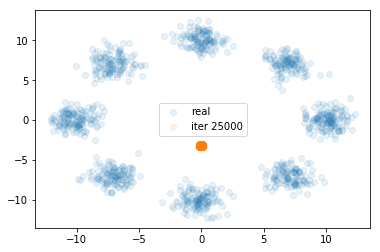

Discriminator: -0.0006828707709722221,	Generator: 0.5820360173661572


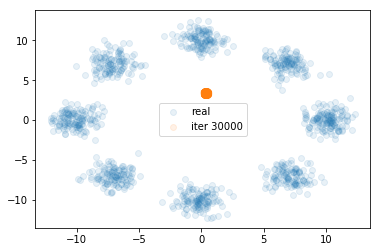

Discriminator: -0.0007558164957006063,	Generator: 0.5837657099111804


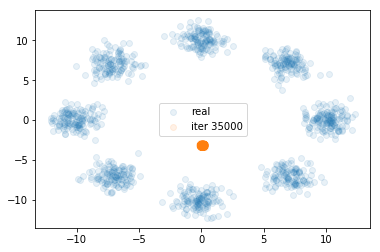

Discriminator: -0.0008183004221366719,	Generator: 0.5852420010565548


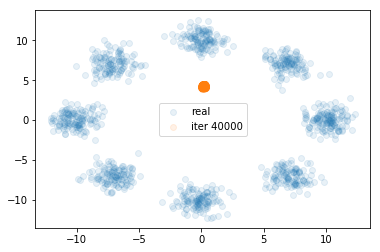

Discriminator: -0.0008843839122148024,	Generator: 0.5863956464402792


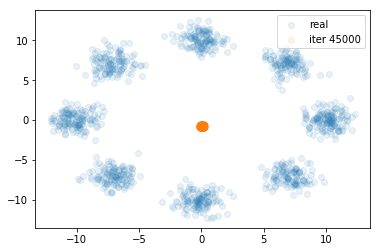

In [9]:
# http://musyoku.github.io/2017/02/06/Wasserstein-GAN/
class WGAN(GAN):
    def loss(self, xs, ts):
        ys = tt.nnet.sigmoid(self.d(xs))
        return tt.mean(ys * (2 * ts[:, numpy.newaxis] - 1))


n_sample = 10000
n_cluster = 8
scale = 10
real = gaussian_mixture_circle(1000, num_cluster=n_cluster, scale=scale)
plt.scatter(real[:, 0], real[:, 1], alpha=0.1)

model = WGAN(lr=1e-5)  #, activation=tt.nnet.relu, weight_init=I.Normal(1e-4))
n_batch = 32
gs_init = model.generate(n_sample)
plt.scatter(gs_init[:, 0], gs_init[:, 1], alpha=0.1)
plt.legend(["real", "init"])
plt.show()

n_critic = 5
n_iters = 50000
n_interval = n_iters // 10
d_loss = 0
g_loss = 0

def clip(model, threshold):
    updates = [(p, p.clip(-threshold, threshold)) for p in model.get_params()]
    return theano.function([], [], updates=updates)

d_clip = clip(model.d, 0.1)

wgan_results = []
for i in range(1, n_iters):
    for n in range(n_critic):
        xs = gaussian_mixture_circle(n_batch, num_cluster=n_cluster, scale=scale)
        d_loss += model.train_d(xs)
        d_clip()
    g_loss += model.train_g(n_batch * 2)
    if numpy.isnan(d_loss + g_loss):
        print("nan detected!")
        break
    if i % n_interval == 0:
        print("Discriminator: {},\tGenerator: {}".format(d_loss / (i * n_critic), g_loss / i))
        gs = model.generate(n_sample)
        plt.scatter(real[:, 0], real[:, 1], alpha=0.1)
        plt.scatter(gs[:, 0], gs[:, 1], alpha=0.1)
        plt.legend(["real", "iter %d" % i])
        plt.show()
        wgan_results.append(Result(i * n_unroll, d_loss / (i * n_critic), g_loss / i, gs))

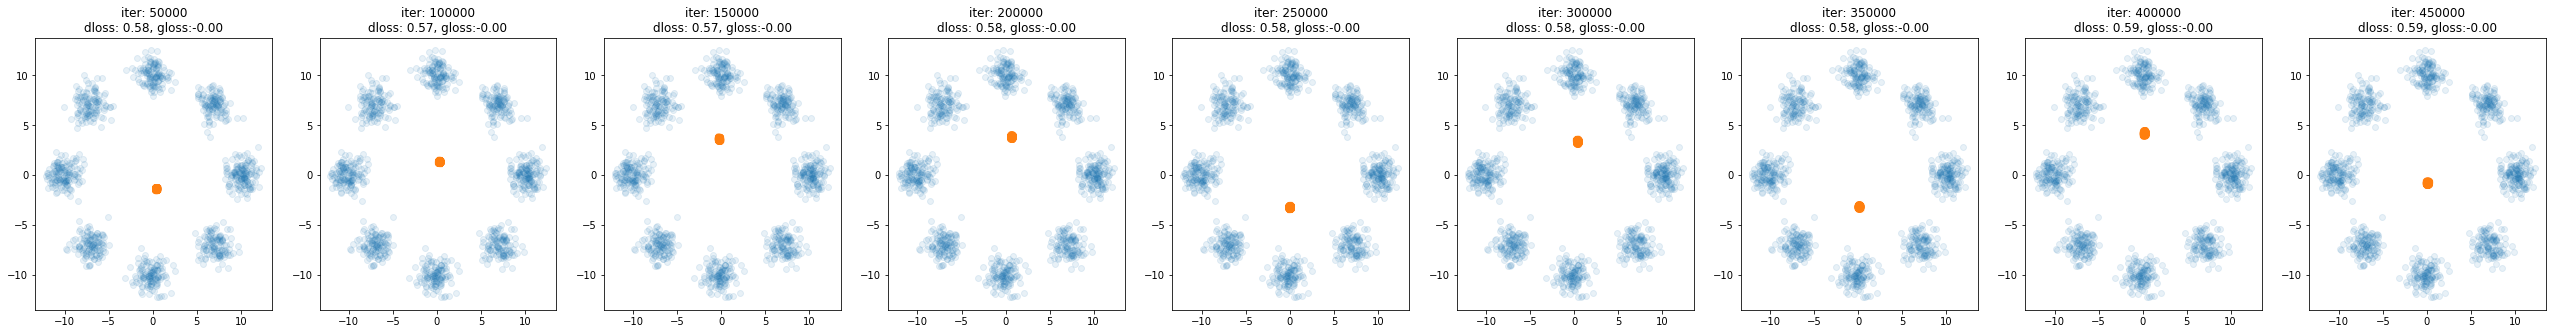

In [10]:
n = len(wgan_results)
fig = plt.figure(figsize=(n * 5,  5)) 
for i, r in enumerate(wgan_results, 1):
    plt.subplot(1, n, i)
    plt.scatter(real[:, 0], real[:, 1], alpha=0.1)
    plt.scatter(r.samples[:, 0], r.samples[:, 1], alpha=0.1)
    plt.title("iter: {}\ndloss: {:.2f}, gloss:{:.2f}".format(r.iter, r.gloss, r.dloss))